# Automatic text recognition

An automatic text recognition (ATR) pipeline, like you e.g. find in Transkribus, typically consists of several components, where the two main are layout detection and text recognition.
In the layout detection step, we analyse an image of text and find all text-lines in the image.
Then, we extract smaller "line images": cropped images that only contain a single line of text, which we input into a text recognition model.
This model takes the cropped line image and outputs the text in that image.

In this notebook, we will only consider the text recognition phase and how you can load state-of-the-art ATR models from the public model repository *Huggingface*.
However, if you are interested in tools for running the full text recognition pipeline, then you can, for example, check out HTR-flow, which the Swedish *Kungliga Biblioteket* have developed for their handwritten text recognition models.

In [1]:
# Uncomment this line if you get ImportErrors below
# !pip install requests torch transformers pillow soxr

In [2]:
import io
from pathlib import Path

import requests
import torch
import transformers
from IPython.display import display
from PIL import Image

/home/mariero/nb-gpt-eval/dhlab-sifi2000-lecture-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download data (if it doesn't exist already)
This code might be a bit confusing, but don't worry about it, it's only included to download the data we need to run this notebook.

In [3]:
url_base = "https://raw.githubusercontent.com/NationalLibraryOfNorway/dhlab-sifi2000-lecture-2025/refs/heads/main/notebooks/"

data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)
paths = (
    [data_dir / f"{i:02d}.png" for i in range(3)]
    + [data_dir / f"{i:02d}.txt" for i in range(3)]
    + [data_dir / "README.md"]
)
for p in paths:
    if not p.exists():
        url = f"{url_base}{p}"
        response = requests.get(url)
        if not response.ok:
            print(f"Could not download {p}, some exercises may not work")

        p.write_bytes(response.content)


## Exercises

* Run all code cells below and reflect: What does each code cell do?
* The ATR-model made some mistakes, what were they, and why do you think it made those mistakes?
* Find the cell where the image is loaded, change it so it loads the `data/01.png` image and `data/01.txt` transcription files instead. Rerun the analysis. How well do you think the model performed?
* Why do you think the ATR-model makes the mistakes it makes?
* Find the cell where the ATR-model and preprocessor is loaded from Huggingface and update the `model_repo`-variabele so it loads the [`Sprakbanken/TrOCR-norhand-v3`](https://huggingface.co/Sprakbanken/TrOCR-norhand-v3) model instead of the [`microsoft/trocr-base-handwritten`](https://huggingface.co/microsoft/trocr-base-handwritten) model. Run all cells again and see if the new model does any better than Microsoft's model. If so, why do you think it did better?

## Bonus exercises

* Write something yourself, either using pen and paper and taking a picture of it, or with a drawing program like paint. Make sure to crop the image so it doesn't contain much other than the text (just one line of text). Try to run TrOCR on the text line image you created.
* If you search for "internett" in a newspaper from year 1900. Search for "internett" in [*nettbiblioteket*](https://www.nb.no/search) and find the newspaper yourself. Why do you think that we can find the word "internett" decades before the internet was invented?

## Load data

Transcription: 'ender interesserede mig meget. Dine penge'


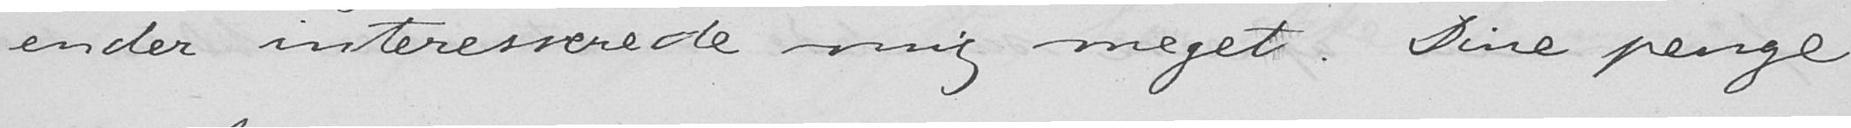

In [4]:
# Specify which image and text file we want to load
image_file = Path("data/00.png")
text_file = Path("data/00.txt")

# Load the image and text file
image = Image.open(io.BytesIO(image_file.read_bytes()))
transcription = text_file.read_text()

# Display the transciption and image
print(f"Transcription: '{transcription}'")
display(image)

## Use an automatic text recognition model

Now, we load a pre-trained ATR model developed by Microsoft named *TrOCR*.
TrOCR-models are a specific type of AI model that thakes an image as input.
It then computes a *numerical representation* of that image, which it uses as input to a small language model.

Note that if you run the code on a PC (or server) without a GPU, it will take long time to run the ATR-model (typically one or more minutes per run, but we can use it on multiple lines simultaneously.)
With a GPU, it takes seconds (if not less).

In [5]:
# Check if we have a GPU available, if so, we want to use it later
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
  print("No GPU available, using CPU. Running the models may be very slow...")

In [6]:
# Load the model from Huggingface
model_repo = "microsoft/trocr-base-handwritten"
processor = transformers.TrOCRProcessor.from_pretrained(model_repo)
model = transformers.VisionEncoderDecoderModel.from_pretrained(model_repo)

# Move the TrOCR model to our compute device (GPU if available, otherwise CPU)
model = model.to(device)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 4837.72it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Preprocess the image so it's ready to be used with our model
pixel_values = processor(images=image.convert("RGB"), return_tensors="pt").pixel_values

# Move the pixel values to the same device as the model
pixel_values = pixel_values.to(device)

# Generate tokens based on the pixel values
generated_ids = model.generate(pixel_values)

# Convert the tokens into text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

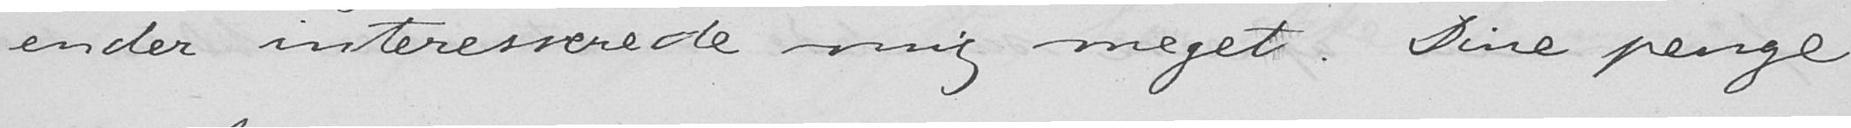

Model transcription: ender intersects made my respect . Since penage
Human transcription: ender interesserede mig meget. Dine penge


In [8]:
# Display the image, generated text and gold-standard transcription
display(image)
print(f"Model transcription: {generated_text}")
print(f"Human transcription: {transcription}")

## Note: Similarities between TrOCR and VLMs

The TrOCR-architecture is in many ways similar to how visual language models (VLMs) are constructed.
The main difference is that since TrOCR is specialised on automatic text recognition, it's not as complicated.
The model we use "only" has $\approx300$ million parameters, compared to the tens to hundreds of billions of parameters general VLMs require.
This means that it's a lot easier to run the models locally so we don't need to share our documents with e.g. OpenAI, and we also reduce our carbon footprint and it can be much much cheaper. Using an open model also makes it easier to evaluate and examine the performance of the model. 
